# TESS Atlas fit for TOI 425

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 425.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-425.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-425.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-425.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 425

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 425 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

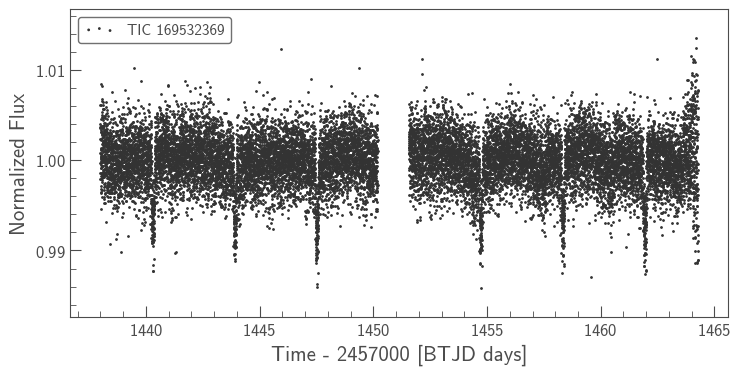

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -52054.35373841795 -> -51933.47119023827


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -42526.38156351161 -> -41863.74605324725


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -41863.74605324725 -> -41774.746732071275


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -41774.746732071275 -> -41774.31079824891


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -41774.31079824891 -> -41773.7499536635


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -41773.7499536635 -> -41773.68095820152


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -41773.68095820152 -> -41769.7895027677


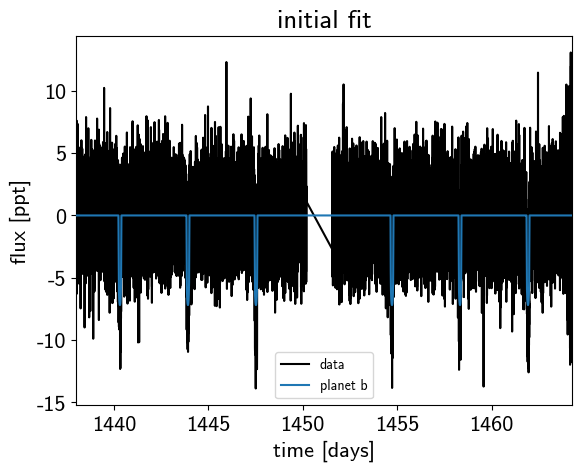

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 16.22draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  8.35draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:14,  6.25draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:16,  5.32draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.81draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:18,  4.52draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:19,  4.33draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:19,  4.21draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:19,  4.07draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:16,  4.85draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:21,  3.63draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:21,  3.44draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:21,  3.47draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:20,  3.52draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:16,  4.34draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:20,  3.31draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:20,  3.27draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:16,  3.90draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:20,  3.12draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:18,  3.53draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:21,  2.93draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:20,  2.97draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:19,  3.08draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:17,  3.21draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:16,  3.33draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:15,  3.51draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:15,  3.44draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:16,  3.21draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:15,  3.21draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:15,  3.19draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:14,  3.33draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:14,  3.35draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:13,  3.55draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:14,  3.21draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:12,  3.67draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:16,  2.74draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:14,  2.93draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:13,  3.03draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:11,  3.24draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:09,  4.05draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:11,  3.27draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:08,  4.09draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:10,  3.26draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:08,  3.65draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:19<00:08,  3.62draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:07,  3.63draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:06,  3.90draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:20<00:06,  3.58draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:06,  3.63draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:06,  3.54draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:06,  3.43draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:05,  3.55draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:05,  3.41draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:22<00:05,  3.44draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.58draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:04,  3.64draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.71draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:23<00:03,  3.78draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:03,  3.76draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:03,  3.82draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.64draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:24<00:03,  3.53draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.58draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:24<00:02,  3.43draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:25<00:02,  3.61draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:25<00:02,  3.45draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:25<00:01,  3.71draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:25<00:01,  3.50draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:26<00:01,  3.72draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:26<00:01,  2.85draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:27<00:00,  2.32draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:28<00:00,  1.83draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:29<00:00,  1.28draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 19.59draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:10,  8.66draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:14,  6.26draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:13,  6.50draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:20,  4.27draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:17,  4.91draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:22,  3.74draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:02<00:21,  3.88draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:23,  3.54draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:22,  3.63draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:03<00:18,  4.27draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:16,  4.85draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:17,  4.46draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:04<00:18,  4.09draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:21,  3.51draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:19,  3.84draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:21,  3.34draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:20,  3.55draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:17,  3.97draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:19,  3.58draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:21,  3.22draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:18,  3.69draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:20,  3.18draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:21,  3.03draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:18,  3.49draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:23,  2.70draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:21,  2.85draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:20,  2.86draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:16,  3.43draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:15,  3.51draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:13,  3.94draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:15,  3.58draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:15,  3.34draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:14,  3.47draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:15,  3.35draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:14,  3.36draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:11,  4.00draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:13,  3.57draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:11,  3.88draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:14,  3.09draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:11,  3.69draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:14<00:09,  4.43draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:11,  3.75draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:10,  3.82draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:11,  3.43draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:10,  3.72draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:11,  3.37draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:10,  3.62draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:12,  2.85draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:11,  2.88draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:17<00:10,  2.94draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:09,  3.04draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:07,  3.63draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:18<00:09,  3.06draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:08,  3.09draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:07,  3.32draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:19<00:07,  3.20draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:19<00:06,  3.56draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:20<00:05,  4.00draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:20<00:04,  4.71draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:21<00:05,  3.29draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:21<00:03,  4.34draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:21<00:04,  3.20draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:04,  3.12draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:22<00:03,  3.86draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:04,  2.87draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:23<00:03,  3.03draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.19draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:24<00:01,  3.76draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:02,  2.99draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:01,  3.04draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:26<00:01,  2.46draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:26<00:00,  2.05draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  2.02draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:29<00:00,  1.11draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:47,  1.88draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:17,  2.58draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:19,  2.51draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:01,  3.24draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:07,  2.94draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:52,  3.70draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:01,  3.19draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:45,  4.26draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:58,  3.26draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:55,  3.42draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:50,  3.72draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:03<00:40,  4.62draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:51,  3.62draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:41,  4.47draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:04<00:37,  4.92draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:04<00:32,  5.54draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:05<00:26,  6.84draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:05<00:31,  5.59draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:30,  5.73draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:06<00:33,  5.10draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:06<00:35,  4.80draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:06<00:38,  4.39draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:07<00:31,  5.42draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:07<00:28,  5.93draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:07<00:29,  5.64draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:07<00:30,  5.49draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:07<00:36,  4.51draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:08<00:34,  4.67draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:08<00:39,  4.11draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:08<00:37,  4.25draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:09<00:32,  4.93draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:09<00:38,  4.13draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:09<00:34,  4.48draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:09<00:32,  4.75draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:09<00:29,  5.19draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:10<00:27,  5.52draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:10<00:23,  6.30draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:10<00:22,  6.59draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:10<00:21,  6.95draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:11<00:25,  5.78draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:11<00:23,  6.25draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:11<00:28,  5.10draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:11<00:32,  4.35draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:12<00:32,  4.28draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:12<00:26,  5.19draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:12<00:29,  4.68draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:12<00:24,  5.61draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:13<00:22,  6.05draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:13<00:30,  4.41draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:13<00:31,  4.16draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:13<00:26,  4.85draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:14<00:26,  4.80draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:14<00:27,  4.69draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:15<00:32,  3.83draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:15<00:25,  4.82draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:15<00:24,  4.97draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:15<00:26,  4.51draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:16<00:25,  4.76draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:16<00:23,  4.97draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:16<00:22,  5.20draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:16<00:20,  5.72draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:16<00:22,  5.05draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:17<00:20,  5.60draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:17<00:17,  6.45draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:17<00:18,  5.92draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:17<00:15,  7.05draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:17<00:15,  7.13draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:18<00:23,  4.62draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:18<00:21,  5.04draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:18<00:18,  5.68draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:18<00:21,  4.92draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:19<00:24,  4.13draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:19<00:20,  4.83draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:19<00:30,  3.29draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:20<00:22,  4.35draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:20<00:27,  3.55draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:20<00:20,  4.61draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:21<00:29,  3.18draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:21<00:26,  3.44draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:21<00:22,  4.08draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:22<00:27,  3.24draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:22<00:22,  4.01draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:22<00:20,  4.20draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:22<00:22,  3.79draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:23<00:27,  3.18draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:23<00:21,  3.90draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:23<00:18,  4.50draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:24<00:22,  3.59draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:24<00:18,  4.29draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:24<00:16,  4.82draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:24<00:22,  3.48draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:25<00:20,  3.63draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:25<00:15,  4.79draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:25<00:18,  3.98draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:26<00:15,  4.63draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:26<00:14,  4.73draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:26<00:14,  4.70draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:27<00:17,  3.79draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:27<00:13,  4.85draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:27<00:14,  4.38draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:27<00:14,  4.22draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:28<00:12,  4.96draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:28<00:14,  4.10draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:28<00:13,  4.34draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:29<00:14,  4.05draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:29<00:10,  5.00draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:29<00:11,  4.55draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:29<00:10,  5.11draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:30<00:10,  4.75draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:30<00:09,  5.43draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:30<00:07,  6.15draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:30<00:10,  4.57draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:30<00:09,  4.95draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:31<00:08,  5.49draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:31<00:07,  5.88draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:31<00:06,  6.29draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:31<00:11,  3.51draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:32<00:09,  4.07draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:32<00:07,  5.16draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:32<00:08,  4.54draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:32<00:06,  5.16draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:33<00:05,  6.38draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:33<00:04,  6.73draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:33<00:05,  5.32draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:33<00:05,  5.49draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:33<00:05,  5.80draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:34<00:05,  5.05draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:34<00:04,  5.47draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:34<00:05,  4.61draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:35<00:03,  5.51draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:35<00:02,  6.33draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:35<00:02,  6.60draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:36<00:03,  4.96draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:36<00:02,  4.83draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:36<00:02,  5.56draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:36<00:02,  4.68draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:37<00:02,  4.92draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:37<00:01,  5.36draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:37<00:02,  3.78draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:37<00:00,  5.03draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:38<00:00,  4.55draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:38<00:00,  4.26draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:39<00:00,  2.81draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:39<00:00,  5.18draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:09, 42.73draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:12, 30.81draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:13, 29.97draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:13, 28.65draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:12, 30.85draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:00<00:11, 32.03draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:12, 30.53draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:00<00:12, 30.66draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:01<00:11, 32.77draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:01<00:12, 30.23draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:01<00:16, 21.72draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:01<00:20, 17.96draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:01<00:18, 19.04draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:01<00:15, 22.51draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:02<00:14, 24.72draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:02<00:14, 24.11draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:15, 21.71draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:02<00:20, 16.84draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:02<00:18, 17.96draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:02<00:19, 17.34draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:17, 18.79draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:03<00:15, 21.02draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:03<00:12, 24.79draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:03<00:13, 23.87draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:03<00:13, 23.49draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:03<00:13, 23.24draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:04<00:12, 24.54draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:04<00:13, 23.11draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:04<00:13, 22.07draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:04<00:14, 20.75draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:04<00:14, 21.01draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:04<00:13, 21.80draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:04<00:12, 23.70draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:04<00:11, 25.29draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:05<00:10, 25.53draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:05<00:10, 26.60draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:05<00:12, 21.10draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:05<00:13, 20.77draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:05<00:12, 21.51draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:05<00:11, 22.88draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:06<00:10, 25.68draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:06<00:08, 29.63draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:06<00:10, 24.07draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:06<00:11, 22.25draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:06<00:12, 19.31draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:06<00:10, 22.82draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:06<00:09, 25.25draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:07<00:08, 28.04draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:07<00:07, 29.04draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:07<00:08, 25.77draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:07<00:09, 24.13draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:07<00:09, 22.96draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:07<00:09, 22.89draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:07<00:08, 24.45draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:08<00:08, 23.38draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:08<00:09, 22.74draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:08<00:07, 25.23draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:08<00:07, 27.50draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:08<00:06, 31.00draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:08<00:05, 33.37draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:08<00:05, 33.68draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:09<00:05, 30.18draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:09<00:06, 27.63draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:09<00:06, 27.95draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:09<00:05, 28.12draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:09<00:06, 25.75draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:09<00:06, 23.93draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:09<00:06, 24.77draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:09<00:05, 25.85draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:10<00:06, 23.14draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:10<00:06, 24.19draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:10<00:05, 25.44draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:10<00:05, 26.58draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:10<00:04, 29.09draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:10<00:03, 33.89draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:10<00:04, 31.72draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:10<00:03, 35.10draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:11<00:04, 26.79draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:11<00:04, 28.63draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:11<00:03, 28.77draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:11<00:03, 27.75draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:11<00:03, 30.49draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:11<00:03, 32.30draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:11<00:02, 33.80draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:11<00:02, 37.11draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:12<00:02, 29.06draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:12<00:02, 28.49draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:12<00:02, 28.22draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:12<00:02, 25.39draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:12<00:02, 25.73draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:12<00:02, 26.48draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:13<00:02, 25.00draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:13<00:02, 26.13draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:13<00:01, 28.95draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:13<00:01, 29.47draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:13<00:01, 32.23draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:13<00:01, 33.56draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:13<00:01, 34.89draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:13<00:00, 35.64draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:13<00:00, 33.49draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:14<00:00, 36.33draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:14<00:00, 25.32draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:14<00:00, 25.27draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:14<00:00, 16.76draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:15<00:00, 16.73draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:15<00:00, 16.97draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:15<00:00, 18.82draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:15<00:00, 20.91draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:15<00:00, 19.22draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:25, 31.13draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:24, 32.98draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:22, 34.73draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:26, 29.87draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:26, 29.85draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:26, 29.85draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:27, 28.16draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:00<00:28, 26.89draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<00:29, 26.03draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:29, 26.06draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:27, 27.41draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:29, 26.01draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:27, 27.17draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:25, 29.08draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:01<00:31, 24.05draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:30, 24.89draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:30, 24.48draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:02<00:30, 24.43draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:26, 27.77draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:02<00:22, 32.26draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:02<00:26, 27.60draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:02<00:29, 24.28draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:03<00:33, 21.31draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:03<00:31, 22.76draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:32, 21.89draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:03<00:33, 21.43draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:03<00:31, 22.67draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:03<00:31, 22.16draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:04<00:41, 16.94draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:04<01:00, 11.49draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:04<00:53, 13.12draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:04<00:57, 12.18draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:04<00:50, 13.76draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:04<00:45, 15.26draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:05<00:42, 16.34draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:05<00:41, 16.65draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:05<00:32, 20.80draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:05<00:30, 22.60draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:05<00:27, 24.20draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:05<00:26, 25.04draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:05<00:25, 26.64draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:05<00:24, 27.21draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:05<00:24, 27.00draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:06<00:26, 25.20draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:06<00:29, 22.05draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:06<00:33, 19.44draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:06<00:33, 19.60draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:06<00:30, 21.36draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:06<00:26, 24.30draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:06<00:25, 25.28draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:07<00:30, 20.53draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:07<00:28, 22.35draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:07<00:25, 25.08draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:07<00:21, 28.81draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:07<00:23, 26.43draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:08<00:39, 15.64draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:08<00:41, 14.95draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:08<00:39, 15.59draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:08<00:34, 17.44draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:08<00:30, 20.00draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:08<00:25, 23.45draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:08<00:22, 26.94draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:09<00:19, 30.64draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:09<00:23, 25.06draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:09<00:22, 26.13draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:09<00:20, 28.34draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:09<00:17, 31.75draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:09<00:16, 33.82draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:09<00:16, 34.24draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:10<00:16, 34.31draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:10<00:16, 34.34draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:10<00:16, 34.09draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:10<00:16, 32.38draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:10<00:18, 29.27draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:10<00:20, 25.63draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:10<00:21, 25.16draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:11<00:21, 24.35draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:11<00:19, 26.46draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:11<00:23, 22.00draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:11<00:21, 23.80draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:11<00:20, 24.81draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:11<00:20, 25.63draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:11<00:19, 25.74draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:11<00:19, 25.67draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:11<00:19, 26.13draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:12<00:21, 23.06draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:12<00:19, 25.17draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:12<00:22, 22.16draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:12<00:23, 21.34draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:12<00:22, 21.42draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:12<00:24, 20.22draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:13<00:24, 20.18draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:13<00:20, 23.66draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:13<00:20, 23.65draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:13<00:20, 22.85draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:13<00:18, 25.43draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:13<00:15, 29.37draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:13<00:14, 31.83draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:13<00:13, 34.95draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:13<00:13, 34.44draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:14<00:12, 36.51draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:14<00:12, 36.83draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:14<00:11, 37.52draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:14<00:11, 37.93draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:14<00:11, 36.04draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:14<00:11, 37.56draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:14<00:11, 35.32draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:14<00:12, 33.26draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:15<00:11, 36.58draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:15<00:10, 37.09draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:15<00:10, 37.16draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:15<00:10, 37.41draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:15<00:10, 36.14draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:15<00:09, 39.13draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:15<00:09, 40.81draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:16<00:10, 34.46draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [00:16<00:09, 38.80draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:16<00:10, 34.43draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:16<00:10, 35.02draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:16<00:11, 30.95draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:16<00:12, 28.74draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:16<00:11, 31.08draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:17<00:10, 32.04draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:17<00:14, 24.12draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:17<00:12, 27.40draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:17<00:11, 27.63draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:17<00:11, 28.78draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:17<00:10, 29.30draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:18<00:11, 27.20draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:18<00:10, 29.47draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:18<00:11, 26.12draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:18<00:10, 28.35draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:18<00:09, 30.20draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:18<00:09, 31.65draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:18<00:09, 31.02draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:18<00:08, 32.14draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:19<00:07, 35.95draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:19<00:08, 32.57draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:19<00:08, 33.37draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:19<00:07, 34.08draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:19<00:07, 35.05draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:19<00:07, 35.94draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:19<00:07, 36.76draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:19<00:07, 33.70draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:19<00:08, 31.29draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:20<00:09, 25.52draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:20<00:10, 23.98draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:20<00:10, 23.16draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:20<00:11, 21.08draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:20<00:11, 20.64draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:21<00:11, 20.28draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:21<00:10, 21.94draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:21<00:09, 23.61draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:21<00:08, 25.45draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:21<00:08, 25.16draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:21<00:07, 27.89draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:21<00:07, 29.40draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:21<00:06, 31.51draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:22<00:05, 35.09draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:22<00:05, 37.06draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:22<00:04, 41.01draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:22<00:04, 42.88draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:22<00:04, 36.69draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:22<00:04, 34.57draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:22<00:04, 36.11draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:23<00:04, 32.68draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:23<00:03, 40.41draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:23<00:05, 28.99draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:23<00:05, 26.11draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:23<00:05, 26.20draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:24<00:05, 24.82draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:24<00:05, 24.81draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:24<00:04, 25.59draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:24<00:05, 24.23draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:24<00:04, 27.25draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:24<00:05, 22.40draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:24<00:06, 18.26draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:25<00:06, 17.15draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:25<00:05, 20.35draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:25<00:05, 20.63draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:25<00:04, 21.71draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:25<00:04, 22.96draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:25<00:05, 18.47draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:26<00:04, 19.25draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:26<00:04, 18.93draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:26<00:04, 20.15draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:26<00:03, 22.12draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:26<00:03, 23.87draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:26<00:03, 24.66draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:26<00:03, 23.68draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:26<00:02, 24.53draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:27<00:02, 23.69draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:27<00:02, 23.87draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:27<00:02, 23.21draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:27<00:02, 24.67draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:27<00:02, 26.28draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:27<00:01, 28.58draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:27<00:01, 28.39draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:27<00:01, 25.80draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:28<00:01, 27.83draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:28<00:01, 31.18draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:28<00:00, 34.85draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:28<00:00, 34.99draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:28<00:00, 36.31draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:28<00:00, 36.02draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:28<00:00, 36.47draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:28<00:00, 36.22draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:28<00:00, 39.42draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:29<00:00, 27.64draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<08:14,  8.90draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<06:12, 11.81draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<05:11, 14.11draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<04:12, 17.37draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<04:03, 18.02draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<04:09, 17.55draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<04:33, 15.99draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<05:01, 14.54draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<04:40, 15.62draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:01<05:39, 12.87draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<05:44, 12.68draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:01<06:31, 11.16draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<05:29, 13.27draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<05:56, 12.26draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:02<06:04, 11.98draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:02<05:48, 12.52draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<05:17, 13.74draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:02<04:29, 16.15draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<04:33, 15.89draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:03<04:13, 17.17draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:03<05:20, 13.57draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:03<04:51, 14.92draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:03<05:04, 14.25draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:03<04:47, 15.10draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:03<05:43, 12.64draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:04<05:42, 12.66draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:04<05:57, 12.12draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:04<05:44, 12.59draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:04<04:44, 15.23draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:04<04:29, 16.07draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:04<03:47, 19.05draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:04<03:24, 21.11draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:04<03:17, 21.88draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:05<04:03, 17.71draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:05<04:21, 16.52draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:05<05:29, 13.09draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:05<04:40, 15.38draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:05<04:25, 16.21draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:06<04:10, 17.15draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:06<04:10, 17.14draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:06<03:53, 18.41draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:06<03:26, 20.77draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:06<03:08, 22.75draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:06<04:02, 17.71draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:07<05:02, 14.15draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:07<05:23, 13.26draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:07<04:42, 15.15draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:07<04:00, 17.74draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:07<03:35, 19.83draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:07<03:13, 22.04draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:07<02:52, 24.74draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:08<03:20, 21.27draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:08<03:08, 22.56draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:08<02:55, 24.29draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:08<03:02, 23.36draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:08<03:11, 22.21draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:08<03:03, 23.19draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:08<02:43, 25.96draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:09<03:28, 20.32draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:09<03:42, 19.00draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:09<03:38, 19.36draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:09<03:23, 20.81draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:09<03:38, 19.38draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:09<03:27, 20.33draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:10<03:20, 21.06draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:10<03:07, 22.54draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:10<03:15, 21.56draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:10<03:06, 22.54draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:10<02:43, 25.67draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:10<02:33, 27.31draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:10<02:35, 26.92draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:10<02:20, 29.93draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:11<02:16, 30.80draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:11<02:16, 30.70draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:11<02:43, 25.52draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:11<02:41, 25.88draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:11<02:43, 25.58draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:11<02:30, 27.76draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:11<02:17, 30.27draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:12<02:27, 28.30draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:12<02:42, 25.65draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:12<02:52, 24.12draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:12<03:39, 18.90draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:12<03:25, 20.21draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:12<03:26, 20.09draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:13<03:56, 17.51draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:13<03:19, 20.75draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:13<03:07, 22.03draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:13<03:00, 22.92draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:13<03:14, 21.20draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:13<03:24, 20.15draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:13<03:09, 21.76draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:14<03:10, 21.63draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:14<02:55, 23.42draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:14<02:36, 26.22draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:14<02:38, 25.91draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:14<02:35, 26.47draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:14<02:32, 26.97draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:14<02:24, 28.44draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:14<02:28, 27.64draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:15<02:21, 28.94draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:15<02:17, 29.75draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:15<02:15, 30.18draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:15<02:07, 31.89draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:15<02:04, 32.66draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:15<02:05, 32.48draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:15<02:12, 30.73draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:16<02:21, 28.73draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:16<02:22, 28.57draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:16<02:33, 26.49draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:16<02:43, 24.82draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:16<02:39, 25.34draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:16<02:32, 26.53draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:16<03:05, 21.81draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:17<03:06, 21.66draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:17<02:56, 22.82draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:17<02:49, 23.79draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:17<02:41, 24.99draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:17<02:17, 29.37draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:17<02:05, 31.90draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:17<02:03, 32.46draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:17<02:01, 32.96draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:17<01:53, 35.35draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:18<01:54, 35.08draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:18<01:55, 34.50draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:18<01:54, 34.82draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:18<01:47, 37.22draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:18<02:02, 32.41draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:18<02:12, 30.09draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:18<02:12, 30.10draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:19<02:09, 30.77draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:19<02:13, 29.82draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:19<02:05, 31.53draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:19<01:58, 33.54draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:19<01:48, 36.57draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:19<02:01, 32.48draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:19<02:06, 31.27draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:19<02:07, 30.84draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:20<02:06, 31.04draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:20<02:42, 24.19draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:20<02:37, 25.00draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:20<02:34, 25.38draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:20<02:30, 26.01draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:20<02:15, 28.92draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:21<02:22, 27.50draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:21<02:22, 27.43draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:21<02:27, 26.57draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:21<02:16, 28.66draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:21<02:23, 27.27draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:21<02:20, 27.77draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:21<02:04, 31.32draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:21<02:00, 32.35draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:22<02:10, 29.73draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:22<02:11, 29.46draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:22<02:08, 30.13draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:22<02:05, 30.86draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:22<02:03, 31.31draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:22<02:15, 28.57draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:22<02:22, 27.16draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:22<02:29, 25.88draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:23<02:53, 22.22draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:23<02:31, 25.36draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:23<02:14, 28.52draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:23<02:01, 31.48draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:23<02:59, 21.38draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:23<02:52, 22.16draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:24<02:55, 21.80draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:24<02:45, 23.18draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:24<03:00, 21.21draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:24<02:38, 24.03draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:24<02:37, 24.23draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:24<02:51, 22.17draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:25<03:23, 18.68draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:25<03:07, 20.31draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:25<02:54, 21.80draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:25<02:50, 22.33draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:25<02:57, 21.34draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:25<02:45, 22.99draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:25<02:49, 22.41draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:25<03:08, 20.09draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:26<03:09, 19.96draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:26<03:01, 20.86draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:26<02:46, 22.71draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:26<02:29, 25.30draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:26<02:08, 29.27draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:26<01:59, 31.59draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:26<01:53, 33.05draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:26<01:52, 33.35draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:27<02:03, 30.49draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:27<02:29, 25.10draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:27<02:38, 23.68draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:27<02:39, 23.43draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:27<02:27, 25.39draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:27<02:13, 28.05draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:27<02:20, 26.64draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:28<02:06, 29.45draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:28<02:15, 27.48draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:28<02:23, 26.03draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:28<02:14, 27.65draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:28<02:20, 26.40draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:28<02:17, 26.97draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:28<02:09, 28.72draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:28<02:00, 30.62draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:29<01:57, 31.60draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:29<02:09, 28.47draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:29<02:00, 30.51draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:29<02:29, 24.71draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:29<02:26, 25.20draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:29<02:39, 23.04draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:30<03:01, 20.26draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:30<02:46, 22.09draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:30<02:28, 24.68draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:30<02:28, 24.68draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:30<02:23, 25.48draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:30<02:12, 27.56draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:30<02:04, 29.34draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:30<02:15, 27.02draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:31<02:14, 27.10draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:31<02:21, 25.72draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:31<02:09, 28.21draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:31<02:04, 29.25draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:31<02:00, 30.16draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:31<01:53, 31.85draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:31<02:22, 25.37draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:32<02:18, 26.20draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:32<02:51, 21.09draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:32<02:41, 22.33draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [00:32<02:42, 22.26draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:32<02:51, 21.04draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:32<02:56, 20.45draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:32<02:48, 21.33draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:33<02:36, 23.06draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [00:33<02:26, 24.62draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:33<02:33, 23.38draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:33<02:33, 23.42draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:33<02:22, 25.16draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:33<02:16, 26.30draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:33<02:27, 24.24draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:33<02:22, 25.19draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:34<02:42, 21.94draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:34<02:48, 21.19draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:34<02:39, 22.40draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:34<02:30, 23.76draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:34<02:35, 22.95draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:34<02:31, 23.44draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:34<02:42, 21.92draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:35<02:49, 20.99draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:35<02:20, 25.33draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:35<02:32, 23.29draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:35<02:28, 23.92draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:35<02:35, 22.77draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:35<02:49, 20.92draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:35<02:35, 22.74draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:36<02:52, 20.44draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:36<02:43, 21.61draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:36<02:45, 21.25draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [00:36<02:57, 19.83draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:36<02:48, 20.94draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:36<02:27, 23.80draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [00:36<02:13, 26.39draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [00:36<02:04, 28.15draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:37<01:51, 31.48draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:37<01:39, 34.99draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [00:37<01:39, 35.16draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:37<01:46, 32.82draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [00:37<01:43, 33.52draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:37<01:57, 29.54draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:37<01:54, 30.44draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:38<02:05, 27.70draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:38<02:05, 27.59draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:38<01:57, 29.38draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:38<01:59, 29.06draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:38<02:03, 27.96draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [00:38<02:08, 26.86draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:38<02:06, 27.24draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:39<02:04, 27.73draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:39<02:05, 27.42draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:39<02:12, 26.00draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:39<02:01, 28.15draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:39<01:59, 28.59draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:39<02:20, 24.33draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:39<02:17, 24.89draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:40<02:10, 26.19draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:40<02:03, 27.70draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:40<02:00, 28.25draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:40<02:02, 27.81draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:40<01:55, 29.51draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:40<01:56, 29.07draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:40<01:49, 31.04draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:40<01:50, 30.56draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [00:41<01:59, 28.36draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:41<01:50, 30.64draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:41<01:47, 31.50draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:41<01:36, 35.06draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:41<01:26, 39.07draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:41<01:24, 39.61draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:41<01:27, 38.35draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:41<01:27, 38.15draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:42<01:33, 35.76draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [00:42<01:42, 32.63draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:42<01:40, 33.23draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:42<01:39, 33.69draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [00:42<01:35, 34.72draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [00:42<01:33, 35.55draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [00:42<01:32, 36.04draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:42<01:31, 36.41draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:43<01:31, 36.23draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:43<01:27, 37.71draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:43<01:26, 38.05draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:43<01:27, 37.51draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:43<01:41, 32.58draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:43<01:52, 29.33draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:43<01:43, 31.70draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [00:43<01:38, 33.43draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:44<01:29, 36.55draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:44<01:33, 35.03draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:44<01:43, 31.61draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [00:44<01:45, 30.84draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:44<01:52, 29.12draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:44<02:06, 25.84draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:44<01:48, 30.06draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:45<01:41, 32.15draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:45<01:32, 35.14draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [00:45<01:29, 36.03draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [00:45<01:28, 36.73draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [00:45<01:35, 34.00draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:45<01:34, 34.35draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:45<01:43, 31.25draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [00:45<01:43, 31.20draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:46<01:51, 28.92draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:46<01:54, 28.10draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [00:46<02:07, 25.22draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:46<02:16, 23.52draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:46<01:53, 28.27draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [00:46<01:47, 29.73draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [00:46<01:51, 28.71draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [00:46<01:55, 27.64draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [00:47<01:50, 28.94draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:47<01:46, 29.94draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:47<01:42, 31.04draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:47<01:52, 28.20draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:47<01:51, 28.49draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [00:47<02:00, 26.22draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [00:47<01:49, 29.01draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:48<01:49, 28.96draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:48<02:04, 25.35draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [00:48<02:03, 25.62draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:48<02:37, 20.02draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:48<02:28, 21.25draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:48<02:20, 22.42draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:48<02:21, 22.26draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [00:49<02:14, 23.28draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:49<02:08, 24.30draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [00:49<02:26, 21.41draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:49<02:19, 22.48draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:49<02:13, 23.32draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:49<02:05, 24.96draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:49<01:59, 26.15draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [00:50<01:54, 27.14draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:50<02:04, 24.95draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:50<02:09, 23.91draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [00:50<01:51, 27.75draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:50<01:41, 30.43draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [00:50<01:43, 29.93draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [00:50<01:36, 32.18draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [00:50<01:32, 33.39draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [00:50<01:33, 32.81draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:51<01:41, 30.20draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [00:51<01:44, 29.47draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:51<01:39, 30.72draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:51<01:42, 29.94draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [00:51<01:45, 28.92draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:51<02:03, 24.76draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:52<01:50, 27.57draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:52<02:03, 24.79draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:52<01:50, 27.56draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:52<01:42, 29.55draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:52<01:30, 33.46draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:52<01:35, 31.75draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:52<01:25, 35.56draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [00:52<01:22, 36.45draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:53<01:19, 38.04draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:53<01:14, 40.61draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [00:53<01:13, 40.99draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:53<01:07, 44.45draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [00:53<01:30, 33.02draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [00:53<01:38, 30.23draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:53<01:33, 31.83draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:54<01:37, 30.60draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [00:54<01:39, 29.79draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:54<01:38, 30.28draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:54<01:54, 25.86draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [00:54<01:46, 27.73draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [00:54<01:37, 30.53draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:54<01:37, 30.45draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [00:54<01:29, 33.11draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:55<01:35, 30.98draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:55<01:45, 27.94draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:55<01:44, 28.27draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:55<01:42, 28.64draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [00:55<01:41, 28.94draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [00:55<01:41, 28.74draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [00:55<01:36, 30.28draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [00:56<01:33, 31.40draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [00:56<01:29, 32.76draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [00:56<01:28, 32.99draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:56<01:40, 29.07draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [00:56<01:46, 27.31draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [00:56<01:53, 25.69draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [00:56<01:49, 26.53draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:56<01:44, 27.62draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [00:57<01:45, 27.47draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [00:57<01:36, 29.86draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [00:57<01:53, 25.33draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [00:57<01:40, 28.69draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [00:57<01:40, 28.53draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [00:57<01:40, 28.59draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [00:57<01:45, 27.08draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [00:58<01:37, 29.32draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:58<01:35, 30.01draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [00:58<01:30, 31.54draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [00:58<01:42, 27.70draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:58<01:44, 27.30draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [00:58<01:42, 27.67draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [00:58<01:40, 28.29draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:59<01:39, 28.39draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:59<01:33, 30.32draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [00:59<01:39, 28.53draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:59<01:32, 30.43draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [00:59<01:30, 31.03draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [00:59<01:27, 32.19draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:59<01:33, 30.19draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [00:59<01:32, 30.41draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:00<01:25, 32.76draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:00<01:10, 39.46draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:00<01:14, 37.58draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:00<01:31, 30.31draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:00<01:47, 25.97draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [01:00<01:38, 28.14draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [01:01<01:53, 24.39draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [01:01<02:13, 20.76draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [01:01<02:06, 21.82draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [01:01<02:05, 22.06draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [01:01<02:15, 20.46draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [01:01<02:45, 16.64draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [01:02<02:33, 17.96draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [01:02<02:30, 18.26draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [01:02<02:20, 19.55draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [01:02<02:26, 18.83draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [01:02<02:28, 18.51draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [01:02<02:30, 18.21draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:02<02:12, 20.64draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [01:03<02:13, 20.57draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [01:03<02:10, 20.90draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [01:03<02:05, 21.84draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:03<01:45, 25.85draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:03<01:50, 24.72draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:03<01:44, 25.95draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [01:03<01:42, 26.54draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:03<01:36, 28.10draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [01:04<01:32, 29.34draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:04<01:33, 28.86draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:04<01:33, 28.79draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:04<01:35, 28.34draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:04<01:54, 23.59draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:04<01:48, 24.82draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:04<01:41, 26.49draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [01:04<01:27, 30.79draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [01:05<01:27, 30.76draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:05<01:21, 32.64draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:05<01:17, 34.49draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:05<01:17, 34.51draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [01:05<01:11, 37.41draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:05<01:11, 37.22draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [01:05<01:10, 37.53draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:05<01:11, 36.81draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [01:06<01:16, 34.63draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [01:06<01:16, 34.63draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:06<01:12, 36.33draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:06<01:11, 36.56draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [01:06<01:15, 34.57draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:06<01:15, 34.77draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:06<01:13, 35.36draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [01:06<01:14, 35.22draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:07<01:21, 32.07draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:07<01:15, 34.45draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:07<01:05, 39.56draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:07<01:00, 42.80draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:07<01:00, 42.85draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:07<01:09, 36.88draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:07<01:10, 36.30draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:07<01:17, 33.14draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [01:08<01:20, 32.03draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [01:08<01:09, 37.10draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [01:08<01:10, 36.31draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:08<01:11, 35.75draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:08<01:14, 34.02draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:08<01:14, 34.28draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:08<01:11, 35.68draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [01:08<01:14, 34.25draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:09<01:16, 33.09draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [01:09<01:12, 34.90draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:09<01:05, 38.51draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:09<01:07, 37.24draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [01:09<01:03, 39.49draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [01:09<01:06, 37.84draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [01:09<01:06, 37.50draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:09<01:10, 35.20draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:10<01:09, 36.11draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:10<01:06, 37.19draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:10<01:07, 36.63draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:10<01:08, 36.11draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:10<01:02, 39.66draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:10<01:00, 41.04draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:10<00:58, 41.84draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:10<00:58, 41.83draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:11<01:00, 40.37draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:11<01:01, 39.61draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:11<00:59, 40.77draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [01:11<00:59, 40.77draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [01:11<01:05, 37.00draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:11<01:09, 34.70draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:11<01:13, 32.96draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [01:11<01:15, 32.11draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [01:12<01:16, 31.66draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [01:12<01:17, 31.24draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:12<01:17, 31.07draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:12<01:16, 31.41draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [01:12<01:19, 30.36draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [01:12<01:17, 31.04draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [01:12<01:13, 32.51draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:13<01:15, 31.46draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [01:13<01:17, 30.92draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [01:13<01:17, 30.84draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:13<01:13, 32.17draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:13<01:12, 32.90draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:13<01:10, 33.68draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [01:13<01:12, 32.46draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:13<01:08, 34.36draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:14<01:05, 36.13draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:14<01:00, 38.64draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:14<01:02, 37.66draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:14<01:08, 34.19draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:14<01:06, 35.27draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:14<01:08, 34.14draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:14<01:02, 37.27draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:14<01:07, 34.25draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [01:15<01:07, 34.57draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:15<01:11, 32.47draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:15<01:12, 31.84draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:15<01:08, 33.56draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:15<01:02, 36.72draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:15<01:01, 37.12draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:15<00:58, 39.35draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [01:16<00:57, 39.81draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:16<01:01, 36.88draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:16<01:01, 37.17draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:16<00:57, 39.76draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:16<00:53, 42.17draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:16<00:54, 41.43draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [01:16<00:55, 40.91draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:16<00:58, 38.32draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:16<00:55, 40.56draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [01:17<00:52, 42.80draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:17<00:53, 41.53draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:17<01:04, 34.73draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:17<01:06, 33.25draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:17<01:10, 31.30draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:17<01:11, 31.07draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [01:17<01:08, 32.11draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:18<01:12, 30.60draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [01:18<01:08, 32.36draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [01:18<01:14, 29.40draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [01:18<01:08, 31.89draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [01:18<01:07, 32.54draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:18<01:11, 30.69draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [01:18<01:16, 28.58draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:19<01:08, 31.64draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:19<01:14, 29.15draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:19<01:05, 33.23draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:19<01:02, 34.81draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [01:19<01:08, 31.64draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:19<01:12, 29.93draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [01:19<01:09, 30.75draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [01:19<01:13, 29.10draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [01:20<01:22, 26.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:20<01:14, 28.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:20<01:11, 29.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [01:20<01:04, 32.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:20<01:05, 32.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [01:20<00:59, 35.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:20<00:57, 36.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [01:21<00:55, 37.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:21<00:54, 38.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:21<00:51, 40.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [01:21<00:53, 38.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:21<01:04, 32.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [01:21<01:05, 32.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:21<00:57, 36.21draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:21<00:53, 38.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [01:22<00:50, 40.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:22<00:58, 35.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:22<00:57, 35.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:22<01:00, 34.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [01:22<01:02, 33.11draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:22<00:55, 37.18draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [01:22<00:53, 38.15draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [01:22<00:48, 42.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [01:23<00:49, 41.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [01:23<00:52, 38.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:23<00:51, 38.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [01:23<00:51, 39.09draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [01:23<00:52, 38.32draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [01:23<00:54, 36.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:23<00:57, 34.68draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:23<00:59, 33.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [01:24<00:53, 37.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [01:24<01:01, 32.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [01:24<00:55, 35.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:24<00:51, 38.18draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [01:24<00:47, 41.80draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:24<00:48, 40.57draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:24<00:46, 42.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [01:25<00:55, 35.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [01:25<00:53, 36.23draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:25<00:51, 38.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [01:25<00:56, 34.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:25<00:53, 36.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:25<00:58, 33.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [01:25<00:56, 34.35draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [01:25<00:52, 36.78draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:26<00:55, 34.60draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [01:26<00:57, 33.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:26<00:55, 34.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:26<00:55, 34.19draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:26<00:57, 33.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [01:26<00:52, 36.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [01:26<00:53, 35.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [01:27<00:55, 34.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [01:27<00:53, 35.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:27<01:04, 29.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:27<01:01, 30.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:27<01:07, 27.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [01:27<01:05, 28.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [01:27<01:00, 30.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [01:28<01:00, 30.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [01:28<00:57, 32.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [01:28<00:53, 34.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [01:28<00:53, 34.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [01:28<00:49, 37.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [01:28<00:51, 35.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [01:28<00:47, 38.73draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [01:28<00:49, 37.21draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [01:29<00:53, 34.28draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [01:29<00:53, 33.78draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:29<00:48, 37.05draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:29<00:48, 37.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [01:29<00:48, 37.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [01:29<00:50, 35.54draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:29<00:51, 35.21draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [01:29<00:53, 33.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:29<00:55, 32.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:30<00:53, 33.57draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [01:30<00:54, 32.64draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [01:30<00:53, 32.97draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [01:30<00:51, 34.09draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:30<00:51, 34.07draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [01:30<00:50, 34.66draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:30<00:55, 31.48draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [01:31<01:00, 29.13draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:31<00:53, 32.74draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [01:31<00:48, 36.19draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:31<00:44, 38.65draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:31<00:48, 35.91draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [01:31<00:52, 33.25draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [01:31<00:55, 31.02draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [01:31<00:55, 30.94draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:32<00:52, 32.51draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [01:32<00:54, 31.57draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [01:32<00:52, 32.61draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:32<00:57, 29.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:32<00:53, 31.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [01:32<00:55, 30.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [01:32<00:57, 29.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:32<00:52, 31.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:33<00:51, 32.51draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:33<00:51, 32.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:33<00:47, 35.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:33<00:52, 31.61draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:33<00:52, 31.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:33<00:50, 33.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:33<00:58, 28.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:34<00:58, 28.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [01:34<00:57, 28.83draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [01:34<00:58, 28.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [01:34<00:58, 28.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:34<00:53, 30.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [01:34<00:46, 35.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [01:34<00:43, 37.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [01:34<00:41, 39.16draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [01:35<00:43, 36.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [01:35<00:47, 34.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:35<00:49, 32.77draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [01:35<00:44, 36.21draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [01:35<00:44, 36.12draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:35<00:43, 36.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [01:35<00:40, 39.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [01:35<00:39, 40.49draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [01:36<00:46, 33.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [01:36<00:48, 32.59draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [01:36<00:49, 31.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [01:36<00:48, 32.10draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:36<00:45, 34.09draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [01:36<00:43, 35.67draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [01:36<00:43, 35.50draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [01:36<00:46, 33.47draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:37<00:47, 32.43draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [01:37<00:47, 32.78draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [01:37<00:47, 32.13draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [01:37<00:47, 32.43draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:37<00:50, 30.34draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:37<00:52, 29.17draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [01:37<00:54, 28.08draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [01:38<00:57, 26.41draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:38<00:55, 27.36draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [01:38<00:54, 27.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [01:38<00:57, 26.27draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [01:38<00:52, 28.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [01:38<00:51, 29.25draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:38<00:47, 31.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [01:38<00:48, 31.18draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [01:39<00:48, 30.71draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [01:39<00:53, 28.01draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [01:39<00:49, 29.79draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [01:39<00:52, 28.24draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [01:39<00:57, 25.53draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [01:39<00:56, 26.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [01:39<00:53, 27.39draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [01:39<00:51, 28.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:40<00:47, 30.82draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [01:40<00:48, 30.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [01:40<00:46, 31.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [01:40<00:44, 32.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [01:40<00:45, 31.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:40<00:45, 31.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [01:40<00:42, 34.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [01:40<00:41, 34.47draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [01:41<00:39, 35.78draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [01:41<00:41, 33.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:41<00:43, 32.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [01:41<00:40, 34.78draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [01:41<00:40, 34.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [01:41<00:36, 38.69draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [01:41<00:35, 39.87draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [01:42<00:38, 36.08draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [01:42<00:40, 34.68draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [01:42<00:38, 36.06draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [01:42<00:41, 33.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [01:42<00:39, 34.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [01:42<00:43, 31.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [01:42<00:37, 35.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [01:42<00:37, 36.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [01:43<00:38, 35.35draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [01:43<00:38, 34.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [01:43<00:40, 33.01draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [01:43<00:41, 32.14draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [01:43<00:40, 33.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [01:43<00:39, 34.18draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [01:43<00:39, 33.96draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [01:43<00:40, 32.52draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [01:44<00:44, 29.97draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [01:44<00:43, 30.44draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [01:44<00:40, 32.23draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [01:44<00:44, 29.40draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [01:44<00:44, 29.12draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [01:44<00:47, 27.49draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [01:44<00:44, 29.10draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [01:45<00:44, 29.48draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [01:45<00:41, 31.02draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [01:45<00:48, 26.79draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:45<00:46, 27.53draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [01:45<00:48, 26.32draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [01:45<00:50, 25.18draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [01:45<00:49, 25.91draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [01:46<00:48, 26.20draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [01:46<00:50, 25.02draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [01:46<00:51, 24.57draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:46<00:46, 27.39draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:46<00:41, 30.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:46<00:44, 28.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [01:46<00:44, 28.20draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [01:46<00:42, 29.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [01:47<00:43, 28.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [01:47<00:40, 30.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [01:47<00:40, 30.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [01:47<00:42, 29.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:47<00:39, 30.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [01:47<00:41, 29.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [01:47<00:36, 32.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [01:47<00:35, 34.46draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [01:48<00:33, 36.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [01:48<00:33, 36.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [01:48<00:32, 37.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [01:48<00:30, 39.58draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [01:48<00:35, 33.82draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [01:48<00:33, 35.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:48<00:31, 37.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [01:49<00:35, 32.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [01:49<00:38, 30.67draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [01:49<00:36, 31.55draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [01:49<00:37, 31.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [01:49<00:38, 30.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [01:49<00:40, 28.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [01:49<00:42, 27.16draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [01:49<00:38, 29.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:50<00:37, 30.25draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [01:50<00:39, 28.99draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [01:50<00:40, 27.79draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:50<00:40, 28.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [01:50<00:40, 28.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [01:50<00:36, 30.46draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [01:50<00:41, 26.73draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [01:51<00:40, 27.50draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [01:51<00:43, 25.44draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [01:51<00:41, 26.63draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [01:51<00:35, 30.92draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [01:51<00:38, 28.47draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:51<00:37, 29.43draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:51<00:33, 32.60draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [01:51<00:32, 33.74draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [01:52<00:33, 32.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [01:52<00:29, 36.46draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [01:52<00:32, 33.43draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [01:52<00:37, 28.43draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [01:52<00:37, 28.11draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [01:52<00:37, 27.96draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:52<00:35, 30.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [01:53<00:40, 25.85draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [01:53<00:42, 24.82draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [01:53<00:43, 24.18draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [01:53<00:44, 23.65draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [01:53<00:41, 25.01draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [01:53<00:39, 26.27draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [01:53<00:39, 26.42draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [01:54<00:40, 25.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [01:54<00:36, 28.28draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [01:54<00:35, 28.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [01:54<00:38, 26.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [01:54<00:34, 29.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [01:54<00:34, 29.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [01:54<00:29, 33.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [01:54<00:27, 36.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [01:54<00:23, 41.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [01:55<00:21, 45.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [01:55<00:32, 30.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [01:55<00:31, 30.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [01:55<00:31, 30.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [01:55<00:31, 31.12draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [01:56<00:30, 31.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [01:56<00:27, 34.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [01:56<00:30, 31.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [01:56<00:32, 29.50draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [01:56<00:32, 28.76draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [01:56<00:34, 27.59draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [01:56<00:35, 26.59draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [01:56<00:34, 27.36draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [01:57<00:34, 26.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [01:57<00:33, 27.41draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [01:57<00:34, 26.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [01:57<00:33, 27.61draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [01:57<00:30, 30.03draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [01:57<00:30, 30.12draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [01:57<00:31, 28.87draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [01:58<00:31, 28.91draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [01:58<00:33, 26.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [01:58<00:32, 27.61draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [01:58<00:31, 27.98draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [01:58<00:29, 30.02draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [01:58<00:32, 27.62draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [01:58<00:34, 25.70draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [01:59<00:35, 24.93draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [01:59<00:31, 27.86draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [01:59<00:28, 30.32draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [01:59<00:25, 33.41draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [01:59<00:27, 31.78draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [01:59<00:25, 33.84draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [01:59<00:23, 36.22draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [01:59<00:25, 32.59draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [02:00<00:30, 27.88draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [02:00<00:33, 25.00draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [02:00<00:28, 28.90draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [02:00<00:28, 29.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [02:00<00:25, 32.33draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [02:00<00:23, 35.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [02:00<00:21, 37.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [02:01<00:21, 38.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [02:01<00:21, 37.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [02:01<00:21, 36.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [02:01<00:22, 34.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:01<00:26, 29.50draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [02:01<00:23, 33.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [02:01<00:22, 35.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:02<00:20, 37.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [02:02<00:21, 35.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [02:02<00:17, 42.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [02:02<00:18, 41.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [02:02<00:21, 35.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:02<00:23, 31.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [02:03<00:28, 25.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [02:03<00:33, 21.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [02:03<00:34, 21.36draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [02:03<00:37, 19.10draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [02:03<00:35, 20.08draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [02:03<00:33, 21.16draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [02:04<00:36, 19.84draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [02:04<00:34, 20.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:04<00:38, 18.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [02:04<00:34, 20.31draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:04<00:36, 19.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [02:04<00:34, 20.37draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:05<00:33, 20.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [02:05<00:33, 20.49draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:05<00:33, 20.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [02:05<00:32, 21.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [02:05<00:35, 19.07draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [02:05<00:34, 20.06draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:05<00:36, 18.62draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [02:06<00:32, 20.92draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:06<00:31, 21.36draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [02:06<00:31, 21.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [02:06<00:32, 20.37draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [02:06<00:28, 23.46draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [02:06<00:34, 19.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [02:06<00:33, 19.81draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [02:07<00:33, 19.43draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [02:07<00:31, 20.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:07<00:32, 19.78draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [02:07<00:36, 17.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [02:07<00:32, 19.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [02:07<00:35, 18.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:08<00:31, 20.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [02:08<00:29, 21.86draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [02:08<00:26, 23.79draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:08<00:23, 26.91draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [02:08<00:22, 27.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:08<00:25, 24.72draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [02:08<00:25, 24.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [02:08<00:28, 21.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:09<00:26, 22.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [02:09<00:25, 23.87draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [02:09<00:24, 24.91draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [02:09<00:27, 21.55draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [02:09<00:28, 20.90draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [02:09<00:27, 21.70draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:09<00:23, 24.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:10<00:26, 22.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [02:10<00:27, 21.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [02:10<00:28, 20.80draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:10<00:28, 20.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [02:10<00:28, 20.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [02:10<00:27, 21.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:10<00:26, 21.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [02:11<00:25, 22.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [02:11<00:23, 23.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [02:11<00:23, 24.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [02:11<00:26, 21.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [02:11<00:24, 22.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [02:11<00:23, 23.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [02:11<00:21, 25.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:11<00:20, 26.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:12<00:18, 29.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:12<00:20, 25.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [02:12<00:22, 23.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [02:12<00:23, 22.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [02:12<00:25, 20.68draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [02:12<00:24, 21.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [02:12<00:22, 23.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [02:13<00:22, 23.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [02:13<00:22, 22.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [02:13<00:20, 24.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [02:13<00:20, 25.34draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [02:13<00:20, 24.82draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:13<00:22, 22.75draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:13<00:21, 23.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [02:13<00:18, 26.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [02:14<00:18, 26.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [02:14<00:21, 23.15draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [02:14<00:20, 24.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [02:14<00:19, 24.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [02:14<00:19, 24.35draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [02:14<00:19, 24.89draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [02:14<00:19, 24.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [02:15<00:20, 22.78draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [02:15<00:22, 20.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [02:15<00:21, 21.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [02:15<00:19, 23.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [02:15<00:17, 25.37draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [02:15<00:17, 25.86draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [02:15<00:16, 27.70draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [02:16<00:15, 27.92draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [02:16<00:15, 28.02draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [02:16<00:15, 27.97draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [02:16<00:17, 24.45draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [02:16<00:16, 25.51draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [02:16<00:15, 27.17draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [02:16<00:15, 27.55draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [02:16<00:19, 22.09draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:17<00:19, 21.11draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:17<00:25, 16.39draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [02:17<00:26, 15.90draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [02:17<00:31, 12.91draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:17<00:33, 12.32draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [02:18<00:31, 13.10draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [02:18<00:30, 13.52draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [02:18<00:25, 15.60draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:18<00:23, 17.12draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [02:18<00:21, 18.81draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:18<00:21, 18.44draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:18<00:22, 17.45draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [02:19<00:26, 14.64draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:19<00:27, 14.21draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [02:19<00:25, 15.00draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:19<00:26, 14.34draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:19<00:27, 13.88draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:19<00:25, 14.74draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:19<00:22, 16.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:20<00:24, 15.26draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [02:20<00:23, 16.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [02:20<00:22, 16.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:20<00:24, 15.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [02:20<00:25, 14.35draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [02:20<00:26, 13.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [02:20<00:24, 14.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [02:21<00:25, 14.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [02:21<00:26, 13.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [02:21<00:24, 14.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [02:21<00:25, 14.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [02:21<00:23, 14.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [02:21<00:24, 14.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [02:21<00:23, 14.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [02:22<00:22, 15.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [02:22<00:20, 16.35draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [02:22<00:24, 14.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [02:22<00:25, 13.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [02:22<00:24, 13.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [02:22<00:24, 13.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [02:22<00:22, 14.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [02:23<00:23, 13.78draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [02:23<00:25, 12.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [02:23<00:26, 12.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [02:23<00:24, 13.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [02:23<00:25, 12.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [02:23<00:23, 13.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [02:24<00:27, 11.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [02:24<00:28, 11.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [02:24<00:30, 10.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [02:24<00:28, 10.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [02:24<00:27, 11.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [02:25<00:29, 10.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [02:25<00:27, 11.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [02:25<00:26, 11.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:25<00:27, 11.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [02:25<00:24, 12.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [02:25<00:22, 13.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [02:25<00:21, 13.99draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [02:26<00:19, 14.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:26<00:20, 14.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [02:26<00:19, 15.18draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [02:26<00:19, 14.48draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [02:26<00:18, 15.30draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [02:26<00:19, 14.55draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [02:26<00:17, 15.78draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [02:27<00:17, 16.26draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:27<00:15, 17.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [02:27<00:16, 16.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [02:27<00:17, 15.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [02:27<00:15, 16.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [02:27<00:17, 15.54draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [02:27<00:16, 16.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [02:28<00:15, 16.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [02:28<00:18, 14.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [02:28<00:17, 14.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [02:28<00:16, 15.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [02:28<00:16, 15.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [02:28<00:15, 16.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [02:28<00:14, 16.73draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [02:28<00:15, 16.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [02:29<00:13, 17.59draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [02:29<00:14, 16.67draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [02:29<00:12, 19.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [02:29<00:12, 19.46draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [02:29<00:14, 16.37draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [02:29<00:15, 15.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [02:30<00:13, 16.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [02:30<00:14, 15.76draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [02:30<00:13, 16.45draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [02:30<00:13, 16.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [02:30<00:13, 15.86draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [02:30<00:12, 16.88draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [02:30<00:13, 15.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [02:30<00:14, 15.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [02:31<00:14, 14.53draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [02:31<00:13, 15.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:31<00:12, 16.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [02:31<00:13, 15.02draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [02:31<00:14, 14.40draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [02:31<00:14, 14.20draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [02:31<00:13, 14.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [02:32<00:12, 15.52draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [02:32<00:12, 16.23draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [02:32<00:12, 15.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [02:32<00:11, 17.24draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [02:32<00:09, 19.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:32<00:09, 19.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [02:32<00:09, 18.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [02:32<00:09, 18.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:33<00:09, 18.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [02:33<00:08, 20.16draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [02:33<00:09, 18.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [02:33<00:09, 18.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:33<00:09, 18.43draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [02:33<00:09, 16.62draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [02:33<00:09, 17.40draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [02:34<00:10, 15.44draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [02:34<00:09, 16.49draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [02:34<00:08, 17.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [02:34<00:08, 18.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [02:34<00:07, 20.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [02:34<00:07, 19.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [02:34<00:08, 17.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [02:35<00:09, 14.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [02:35<00:09, 14.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [02:35<00:09, 13.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [02:35<00:10, 13.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [02:35<00:09, 13.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [02:35<00:10, 12.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:36<00:11, 11.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [02:36<00:11, 11.30draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [02:36<00:11, 11.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [02:36<00:09, 12.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [02:36<00:07, 15.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [02:36<00:09, 12.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [02:37<00:09, 11.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [02:37<00:09, 11.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [02:37<00:09, 12.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [02:37<00:08, 13.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:37<00:08, 12.92draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:37<00:08, 12.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [02:38<00:08, 12.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [02:38<00:07, 12.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [02:38<00:07, 13.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:38<00:08, 11.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [02:38<00:08, 11.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [02:39<00:08, 11.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [02:39<00:07, 12.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:39<00:06, 13.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [02:39<00:06, 13.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:39<00:06, 12.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [02:39<00:06, 12.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [02:39<00:05, 13.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [02:40<00:05, 14.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [02:40<00:05, 13.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [02:40<00:05, 14.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:40<00:05, 13.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [02:40<00:05, 13.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [02:40<00:05, 12.53draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:41<00:05, 12.24draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [02:41<00:05, 12.33draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [02:41<00:05, 12.38draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [02:41<00:04, 13.15draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [02:41<00:04, 12.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [02:41<00:03, 14.23draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [02:41<00:04, 12.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [02:42<00:03, 13.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [02:42<00:03, 13.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [02:42<00:03, 12.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [02:42<00:03, 12.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [02:42<00:03, 11.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [02:43<00:03, 11.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [02:43<00:02, 12.86draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [02:43<00:02, 12.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [02:43<00:02, 13.67draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [02:43<00:02, 14.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [02:43<00:01, 15.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [02:43<00:01, 16.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [02:44<00:01, 16.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [02:44<00:01, 16.33draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [02:44<00:01, 15.50draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [02:44<00:00, 17.16draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [02:44<00:00, 17.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [02:44<00:00, 14.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [02:44<00:00, 16.50draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [02:44<00:00, 17.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [02:45<00:00, 17.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [02:45<00:00, 16.39draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [02:45<00:00, 16.73draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:45<00:00, 26.62draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:25, 39.08draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:26, 36.89draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:28, 34.40draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:26, 37.59draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:27, 36.25draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:00<00:26, 37.21draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:00<00:33, 29.45draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<00:35, 27.50draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:32, 29.55draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:01<00:28, 33.49draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:01<00:37, 25.45draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:37, 25.58draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:01<00:34, 27.90draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:01<00:34, 27.18draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:02<00:31, 29.97draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:02<00:27, 33.72draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:02<00:43, 21.52draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:02<00:54, 16.96draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:02<00:52, 17.54draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:03<00:48, 19.12draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:03<00:53, 17.18draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:03<00:54, 16.85draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:03<00:46, 19.51draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:03<00:38, 23.29draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:03<00:36, 24.88draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:03<00:32, 28.00draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:04<00:36, 24.53draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:04<00:46, 19.32draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:04<00:46, 19.02draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:04<00:42, 21.00draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:04<00:39, 22.55draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:04<00:34, 25.68draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:04<00:32, 26.79draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:05<00:36, 23.71draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:05<00:38, 22.70draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:05<00:37, 23.16draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:05<00:31, 27.03draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:05<00:34, 24.52draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:05<00:31, 26.76draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:05<00:27, 30.74draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:06<00:29, 28.92draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:06<00:31, 26.83draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:06<00:28, 29.39draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:06<00:28, 29.52draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:06<00:29, 27.88draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:06<00:34, 23.64draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:07<00:40, 20.12draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:47, 17.22draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:07<00:50, 16.19draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:07<00:56, 14.39draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:07<01:04, 12.65draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:08<01:06, 12.17draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:08<00:58, 13.86draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:08<00:48, 16.46draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:08<00:46, 17.27draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:08<00:42, 19.01draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:08<00:39, 20.17draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:08<00:39, 20.22draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:09<00:47, 16.78draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:09<00:50, 15.51draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:09<00:47, 16.62draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:09<00:41, 18.88draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:09<00:37, 20.80draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:09<00:34, 22.48draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:09<00:36, 21.19draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:10<00:38, 20.08draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:10<00:36, 21.14draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:10<00:38, 19.77draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:10<00:41, 18.44draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:10<00:42, 17.66draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:10<00:37, 19.94draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:10<00:35, 21.15draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:10<00:32, 22.73draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:11<00:29, 25.58draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:11<00:28, 26.11draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:11<00:25, 28.82draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:11<00:27, 26.71draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:11<00:30, 23.87draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:11<00:37, 19.56draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:11<00:34, 20.81draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:12<00:33, 21.35draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:12<00:33, 21.78draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:12<00:34, 20.65draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:12<00:33, 21.31draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:12<00:32, 21.72draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:12<00:30, 23.33draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:12<00:34, 20.56draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:13<00:32, 21.78draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:13<00:30, 22.91draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:13<00:30, 22.76draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:13<00:28, 23.94draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:13<00:27, 24.58draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:13<00:29, 23.44draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:13<00:27, 25.05draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:14<00:26, 25.37draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:14<00:23, 28.40draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:14<00:19, 33.43draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:14<00:22, 28.83draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:14<00:22, 29.23draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:14<00:25, 26.11draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:14<00:26, 24.91draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:14<00:23, 27.68draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:15<00:21, 29.29draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:15<00:22, 29.04draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:15<00:20, 31.75draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:15<00:18, 33.60draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:15<00:20, 30.80draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:15<00:20, 29.94draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:15<00:23, 26.23draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:16<00:24, 25.15draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:16<00:23, 25.72draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:16<00:21, 27.75draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:16<00:19, 30.24draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:16<00:20, 29.37draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:16<00:20, 28.59draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:16<00:20, 29.20draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:17<00:18, 31.49draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:17<00:17, 33.12draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:17<00:15, 37.79draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:17<00:18, 31.63draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:17<00:17, 31.83draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:17<00:19, 28.27draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:18<00:23, 23.85draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:18<00:19, 27.74draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:18<00:18, 29.21draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:18<00:26, 20.61draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:18<00:23, 22.74draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:18<00:24, 22.21draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:19<00:27, 19.16draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:19<00:31, 16.71draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:19<00:25, 20.78draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:19<00:28, 18.43draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:19<00:25, 20.64draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:19<00:20, 24.75draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:20<00:28, 17.94draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:20<00:29, 17.14draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:20<00:25, 19.75draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:20<00:23, 21.55draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:20<00:26, 19.03draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:21<00:27, 17.74draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:21<00:25, 19.01draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:21<00:27, 17.69draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:21<00:24, 19.98draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:21<00:23, 20.66draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:21<00:21, 22.78draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:21<00:21, 22.71draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:22<00:19, 24.51draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:22<00:18, 25.06draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:22<00:18, 25.60draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:22<00:16, 27.89draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:22<00:15, 29.52draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:22<00:15, 29.97draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:22<00:13, 33.45draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:22<00:12, 36.19draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:23<00:12, 34.26draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:23<00:13, 31.13draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:23<00:13, 32.49draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:23<00:11, 37.14draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:23<00:11, 38.01draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:23<00:12, 32.75draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:23<00:12, 32.98draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:23<00:13, 31.04draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:24<00:11, 34.34draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:24<00:11, 34.05draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [00:24<00:11, 35.60draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:24<00:10, 37.48draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:24<00:10, 36.20draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:24<00:09, 38.58draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:24<00:10, 35.75draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:24<00:10, 36.40draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:25<00:11, 31.82draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:25<00:10, 33.68draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:25<00:12, 28.46draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:25<00:12, 29.18draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:25<00:11, 30.82draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:25<00:12, 27.79draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:25<00:12, 27.14draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:26<00:13, 25.79draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:26<00:11, 28.31draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:26<00:11, 29.49draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:26<00:11, 27.87draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:26<00:10, 30.28draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:26<00:09, 32.93draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:26<00:09, 34.43draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:27<00:08, 36.18draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:27<00:09, 32.10draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:27<00:09, 30.98draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:27<00:09, 31.22draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:27<00:08, 33.19draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:27<00:07, 36.88draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:27<00:07, 36.78draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:27<00:08, 34.29draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:28<00:08, 32.26draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:28<00:08, 33.08draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:28<00:08, 31.40draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:28<00:08, 29.77draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:28<00:08, 28.38draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:28<00:08, 28.21draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:28<00:09, 27.12draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:29<00:08, 29.51draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:29<00:07, 32.29draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:29<00:08, 26.70draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:29<00:09, 25.27draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [00:29<00:08, 28.29draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:29<00:07, 30.98draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:29<00:07, 28.45draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:30<00:08, 24.49draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:30<00:09, 22.01draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:30<00:08, 23.98draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:30<00:08, 24.07draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:30<00:07, 25.57draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:30<00:07, 27.27draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:30<00:07, 26.92draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:30<00:07, 26.94draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:31<00:06, 29.84draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:31<00:06, 27.88draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [00:31<00:05, 32.06draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:31<00:05, 29.70draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:31<00:05, 33.74draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:31<00:04, 35.02draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:31<00:04, 36.37draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:31<00:05, 30.27draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:32<00:06, 22.30draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:32<00:08, 16.89draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:32<00:09, 16.21draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:33<00:10, 13.95draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:33<00:10, 13.90draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:33<00:10, 14.09draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:33<00:10, 12.82draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:33<00:11, 12.12draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:33<00:09, 13.64draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:33<00:09, 14.18draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:34<00:10, 12.13draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:34<00:11, 11.68draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:34<00:11, 11.48draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:34<00:11, 11.34draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:34<00:11, 10.91draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:35<00:11, 10.86draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:35<00:10, 10.99draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:35<00:10, 11.61draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:35<00:10, 11.23draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:35<00:09, 12.03draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:35<00:09, 11.92draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:36<00:07, 14.48draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [00:36<00:07, 14.59draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:36<00:07, 14.65draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:36<00:06, 15.81draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:36<00:05, 17.35draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:36<00:05, 16.66draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:36<00:06, 13.98draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:37<00:06, 14.15draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:37<00:06, 14.43draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:37<00:06, 14.63draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:37<00:05, 14.75draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:37<00:05, 14.90draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:37<00:05, 13.95draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:37<00:05, 14.34draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:38<00:05, 14.58draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:38<00:05, 13.30draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:38<00:05, 13.31draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:38<00:05, 13.80draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:38<00:05, 13.63draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:38<00:04, 14.10draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:38<00:04, 15.75draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:39<00:03, 18.19draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:39<00:03, 18.23draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:39<00:02, 19.72draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:39<00:02, 18.08draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:39<00:02, 18.60draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:39<00:02, 18.96draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:39<00:02, 16.84draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:40<00:02, 17.87draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:40<00:02, 18.30draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:40<00:01, 20.62draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:40<00:01, 21.53draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:40<00:01, 19.54draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:40<00:01, 17.69draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:40<00:01, 16.69draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [00:41<00:01, 16.45draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [00:41<00:01, 14.98draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:41<00:01, 14.70draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:41<00:01, 14.25draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:41<00:01, 14.20draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:41<00:01, 14.33draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:41<00:00, 14.50draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:42<00:00, 16.67draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:42<00:00, 16.38draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:42<00:00, 15.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [00:42<00:00, 17.58draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:42<00:00, 15.71draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:42<00:00, 23.54draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:14, 26.65draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<01:12, 27.45draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<01:06, 29.74draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:04, 30.80draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<01:08, 28.72draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:08, 28.83draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<01:02, 31.45draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<01:06, 29.45draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:01<01:05, 30.10draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:05, 30.16draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:01<01:07, 28.86draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:01<01:09, 28.05draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<01:10, 27.73draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<01:07, 28.84draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<01:07, 28.91draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:01<01:04, 30.09draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:02<01:05, 29.46draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:02<01:14, 25.81draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:02<01:06, 28.97draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:02<01:06, 29.06draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:02<01:13, 26.09draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<01:14, 25.58draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:02<01:15, 25.37draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:03<01:13, 25.94draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:03<01:13, 25.84draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:25, 22.18draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:03<01:19, 24.05draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<01:10, 27.04draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:03<01:26, 21.96draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:03<01:22, 22.98draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:04<01:21, 23.14draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:04<01:20, 23.53draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:04<01:11, 26.26draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:04<01:07, 27.83draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:04<01:06, 28.31draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:04<01:05, 28.57draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:04<01:06, 28.26draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:04<01:00, 30.90draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:05<00:57, 32.06draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:05<01:01, 29.96draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:05<01:10, 26.31draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:05<01:10, 26.13draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:05<01:11, 25.85draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:05<01:09, 26.47draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:05<01:07, 27.10draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:06<01:07, 27.12draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:06<01:05, 27.81draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:06<00:59, 30.56draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:06<01:04, 28.04draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:06<01:07, 26.76draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:06<01:03, 28.79draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:06<01:09, 25.99draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:06<01:06, 27.30draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:07<01:14, 24.33draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:07<01:11, 25.30draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:07<01:18, 23.03draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:07<01:22, 21.76draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:07<01:23, 21.44draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:07<01:18, 22.73draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:07<01:15, 23.76draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:08<01:13, 24.21draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:08<01:14, 23.92draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:08<01:11, 24.81draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:08<01:12, 24.51draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:08<01:17, 22.78draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:08<01:09, 25.32draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:08<01:06, 26.28draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:09<01:07, 26.08draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:09<01:05, 26.66draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:09<01:04, 27.15draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:09<01:06, 26.42draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:09<01:08, 25.39draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:09<01:01, 28.10draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:09<01:04, 26.79draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:09<01:06, 25.97draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:09<01:02, 27.50draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:10<01:03, 27.40draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:10<01:09, 24.80draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:10<01:17, 22.19draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:10<01:09, 24.60draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:10<01:04, 26.47draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:10<01:11, 23.86draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:10<01:09, 24.65draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:11<01:09, 24.55draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:11<01:05, 25.98draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:11<00:49, 34.13draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:11<00:50, 33.53draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:11<00:57, 28.92draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:11<00:57, 28.91draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:11<00:53, 31.22draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:12<00:59, 27.85draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:12<00:57, 28.85draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:12<00:56, 29.48draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:12<00:56, 29.32draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:12<00:55, 29.45draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:12<00:57, 28.59draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:12<00:57, 28.61draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:13<01:01, 26.47draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:13<00:54, 30.03draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:13<00:53, 30.15draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:13<00:50, 32.42draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:13<00:53, 30.12draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:13<00:55, 29.10draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:13<00:50, 31.67draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:14<00:52, 30.50draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:14<00:56, 28.52draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:14<00:55, 28.90draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:14<00:54, 29.32draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:14<00:53, 29.47draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:14<00:52, 30.24draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:14<00:56, 27.93draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:14<00:51, 30.87draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:15<00:53, 29.66draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:15<00:49, 31.91draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:15<00:49, 31.80draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:15<00:47, 32.84draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:15<00:51, 30.20draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:15<00:49, 31.10draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:15<00:50, 30.66draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:15<00:50, 30.49draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:16<00:50, 30.47draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:16<00:47, 32.56draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:16<00:51, 29.64draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:16<00:48, 31.72draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:16<00:45, 33.43draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:16<00:47, 32.02draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:16<00:43, 35.16draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:17<00:45, 33.03draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:17<00:45, 32.94draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:17<00:49, 30.60draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:17<00:50, 29.56draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:17<00:48, 30.84draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:17<00:46, 32.34draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:17<00:43, 33.98draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:17<00:49, 30.23draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:18<00:46, 31.83draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:18<00:53, 27.50draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:18<00:48, 30.33draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:18<00:47, 30.63draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:18<00:47, 30.76draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:18<00:46, 31.39draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:18<00:50, 28.69draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:19<00:49, 29.34draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:19<00:43, 33.18draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:19<00:46, 31.04draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:19<00:42, 33.44draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:19<00:47, 30.11draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:19<00:45, 31.57draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:19<00:46, 30.54draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:20<00:46, 30.49draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:20<00:46, 30.14draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:20<00:45, 30.87draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:20<00:43, 32.60draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:20<00:44, 31.87draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:20<00:42, 32.56draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:20<00:42, 32.46draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:20<00:41, 33.66draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:21<00:42, 32.54draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:21<00:39, 35.19draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:21<00:36, 38.16draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:21<00:40, 34.28draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:21<00:42, 32.22draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:21<00:42, 32.28draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:21<00:42, 32.36draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:21<00:41, 32.39draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:22<00:45, 29.56draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:22<00:46, 28.92draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:22<00:43, 31.04draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:22<00:40, 33.27draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:22<00:41, 32.27draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:22<00:41, 31.71draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:22<00:39, 33.10draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:23<00:38, 34.54draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:23<00:34, 38.02draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:23<00:36, 35.41draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:23<00:36, 36.25draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:23<00:34, 37.20draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:23<00:35, 36.89draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:23<00:32, 39.63draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:23<00:34, 37.32draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:23<00:34, 37.53draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:24<00:31, 40.26draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:24<00:34, 37.04draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:24<00:34, 36.45draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:24<00:34, 36.19draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:24<00:37, 34.03draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:24<00:33, 37.52draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:24<00:30, 40.48draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:24<00:33, 36.71draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:25<00:37, 32.68draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:25<00:35, 34.88draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:25<00:35, 34.76draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:25<00:33, 36.38draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:25<00:33, 36.61draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:25<00:35, 34.48draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:25<00:39, 30.48draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:26<00:48, 25.18draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:26<00:51, 23.57draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:26<00:49, 24.51draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:26<00:51, 23.13draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:26<00:49, 24.14draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:26<00:47, 25.38draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:26<00:42, 28.30draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:27<00:41, 28.67draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:27<00:44, 26.68draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:27<00:46, 25.62draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:27<00:43, 26.87draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:27<00:38, 30.39draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:27<00:37, 31.51draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:27<00:33, 34.30draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:27<00:36, 31.76draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:28<00:34, 33.45draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:28<00:31, 35.95draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:28<00:31, 36.59draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:28<00:34, 33.43draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:28<00:33, 33.44draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:28<00:32, 34.34draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:28<00:35, 31.61draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:28<00:31, 35.25draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:28<00:32, 34.68draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:29<00:32, 34.39draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:29<00:35, 31.39draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:29<00:36, 30.67draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:29<00:38, 28.80draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:29<00:37, 29.28draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:29<00:36, 29.69draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:29<00:34, 31.56draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:30<00:34, 31.71draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:30<00:34, 31.37draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:30<00:32, 33.22draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:30<00:31, 34.29draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:30<00:31, 34.18draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:30<00:32, 32.93draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:30<00:35, 30.09draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:30<00:32, 32.29draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:31<00:37, 28.30draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:31<00:37, 28.30draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:31<00:36, 28.48draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:31<00:37, 27.64draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:31<00:38, 26.93draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:31<00:36, 28.12draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:31<00:34, 30.33draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:31<00:36, 28.00draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:32<00:36, 27.86draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:32<00:37, 27.38draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:32<00:37, 27.22draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:32<00:37, 27.28draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:32<00:33, 29.93draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:32<00:36, 27.79draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:32<00:35, 28.08draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:33<00:32, 30.56draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:33<00:31, 31.78draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:33<00:32, 30.98draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:33<00:32, 30.20draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:33<00:31, 31.61draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:33<00:33, 29.42draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:33<00:31, 31.38draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:33<00:33, 28.77draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:34<00:33, 28.83draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:34<00:35, 27.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:34<00:31, 30.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:34<00:31, 30.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:34<00:28, 33.17draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [00:34<00:31, 29.79draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:34<00:29, 32.18draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:34<00:30, 31.31draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:35<00:28, 32.96draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:35<00:27, 34.21draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:35<00:26, 34.82draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:35<00:28, 32.41draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:35<00:29, 30.84draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:35<00:30, 30.23draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:35<00:27, 33.18draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:36<00:27, 32.92draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:36<00:27, 33.14draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:36<00:28, 31.52draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:36<00:26, 33.37draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [00:36<00:25, 34.57draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:36<00:26, 33.51draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [00:36<00:25, 34.41draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:36<00:25, 34.26draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [00:37<00:28, 30.86draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:37<00:28, 30.09draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:37<00:30, 28.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:37<00:29, 28.77draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:37<00:30, 28.60draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:37<00:31, 27.02draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [00:37<00:30, 28.32draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:37<00:29, 28.52draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:38<00:28, 29.91draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:38<00:26, 31.86draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:38<00:25, 32.73draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:38<00:24, 34.13draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [00:38<00:26, 30.84draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [00:38<00:29, 27.89draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:38<00:29, 28.16draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:38<00:27, 30.10draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:39<00:27, 30.01draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:39<00:27, 29.38draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [00:39<00:24, 33.30draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:39<00:23, 33.47draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:39<00:24, 32.98draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:39<00:21, 36.30draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [00:39<00:21, 36.41draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:39<00:24, 32.06draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [00:40<00:22, 35.14draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:40<00:23, 33.39draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [00:40<00:21, 35.00draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:40<00:21, 35.00draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:40<00:23, 32.71draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:40<00:23, 32.41draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [00:40<00:21, 34.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [00:40<00:21, 34.64draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [00:41<00:22, 32.68draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [00:41<00:21, 34.26draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:41<00:22, 32.78draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:41<00:21, 34.35draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [00:41<00:20, 35.11draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:41<00:20, 35.12draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [00:41<00:18, 38.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:41<00:20, 35.14draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [00:42<00:21, 32.40draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [00:42<00:21, 33.14draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:42<00:20, 33.40draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [00:42<00:20, 34.02draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:42<00:20, 33.16draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:42<00:23, 29.28draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:42<00:22, 30.17draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:42<00:23, 29.34draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:43<00:22, 29.52draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [00:43<00:22, 29.98draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [00:43<00:23, 28.74draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:43<00:21, 31.00draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:43<00:18, 36.07draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:43<00:18, 35.23draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:43<00:18, 34.99draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [00:43<00:18, 35.32draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [00:44<00:17, 36.60draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [00:44<00:16, 37.92draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [00:44<00:17, 36.93draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:44<00:16, 37.56draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [00:44<00:20, 30.89draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [00:44<00:18, 32.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [00:44<00:20, 29.65draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:45<00:20, 29.23draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:45<00:22, 26.97draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:45<00:23, 25.84draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [00:45<00:21, 27.72draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [00:45<00:21, 27.87draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [00:45<00:22, 26.89draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:45<00:22, 26.30draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:45<00:21, 27.19draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:46<00:20, 27.88draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:46<00:23, 24.96draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [00:46<00:22, 25.22draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:46<00:22, 25.65draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:46<00:20, 27.90draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:46<00:19, 29.00draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:46<00:18, 29.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [00:46<00:17, 31.32draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [00:46<00:16, 33.19draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [00:47<00:17, 32.02draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:47<00:16, 33.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [00:47<00:15, 34.44draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [00:47<00:16, 33.38draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [00:47<00:15, 34.57draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:47<00:15, 35.39draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [00:47<00:15, 33.30draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [00:47<00:13, 37.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [00:48<00:14, 35.18draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [00:48<00:14, 34.75draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [00:48<00:14, 35.09draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:48<00:14, 35.37draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:48<00:13, 36.58draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [00:48<00:14, 34.64draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [00:48<00:12, 37.83draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [00:48<00:13, 35.51draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [00:49<00:14, 33.53draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:49<00:14, 32.78draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:49<00:14, 33.77draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [00:49<00:13, 35.70draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [00:49<00:12, 36.28draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [00:49<00:13, 34.28draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [00:49<00:12, 37.70draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [00:49<00:12, 36.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [00:49<00:12, 34.57draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [00:50<00:10, 40.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:50<00:11, 39.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [00:50<00:11, 36.17draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:50<00:10, 39.47draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [00:50<00:10, 39.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [00:50<00:10, 38.99draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:50<00:10, 38.76draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [00:51<00:09, 42.16draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:51<00:09, 39.92draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [00:51<00:10, 38.62draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [00:51<00:10, 38.83draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:51<00:09, 39.06draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [00:51<00:09, 38.55draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [00:51<00:10, 35.24draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [00:51<00:10, 35.64draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [00:52<00:10, 35.72draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [00:52<00:09, 36.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [00:52<00:09, 37.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [00:52<00:09, 38.67draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [00:52<00:09, 35.97draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [00:52<00:09, 36.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [00:52<00:10, 33.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [00:52<00:10, 31.52draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:53<00:10, 32.37draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [00:53<00:09, 33.26draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [00:53<00:09, 34.72draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [00:53<00:08, 39.46draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [00:53<00:08, 37.89draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [00:53<00:08, 34.92draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [00:53<00:09, 31.59draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [00:53<00:09, 30.55draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [00:54<00:08, 34.23draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:54<00:09, 32.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [00:54<00:09, 31.41draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [00:54<00:08, 32.14draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [00:54<00:08, 33.66draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [00:54<00:08, 31.55draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [00:54<00:09, 27.75draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:55<00:09, 29.03draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [00:55<00:09, 28.85draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:55<00:09, 28.46draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [00:55<00:09, 26.43draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [00:55<00:08, 28.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [00:55<00:09, 25.70draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [00:55<00:09, 24.75draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [00:56<00:09, 25.99draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [00:56<00:10, 23.68draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [00:56<00:10, 23.18draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [00:56<00:10, 22.77draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [00:56<00:09, 22.93draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [00:56<00:09, 24.63draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [00:56<00:09, 24.21draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [00:56<00:08, 24.75draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [00:57<00:08, 24.13draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [00:57<00:08, 26.31draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [00:57<00:09, 23.16draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [00:57<00:08, 24.66draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [00:57<00:07, 25.61draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [00:57<00:08, 24.69draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [00:57<00:07, 25.66draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [00:57<00:07, 26.81draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [00:57<00:06, 27.66draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [00:58<00:06, 29.83draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [00:58<00:05, 33.21draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:58<00:06, 28.81draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [00:58<00:09, 18.52draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [00:59<00:10, 16.15draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [00:59<00:09, 17.38draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:59<00:09, 16.98draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [00:59<00:10, 15.16draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [00:59<00:12, 13.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [00:59<00:12, 12.78draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:00<00:12, 12.49draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:00<00:11, 13.01draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:00<00:11, 13.71draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:00<00:10, 14.26draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [01:00<00:09, 15.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:00<00:10, 14.02draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:00<00:10, 13.52draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:01<00:10, 13.42draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:01<00:10, 12.91draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:01<00:09, 14.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:01<00:10, 13.26draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [01:01<00:10, 12.82draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:01<00:10, 12.15draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:02<00:09, 13.15draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:02<00:08, 14.38draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:02<00:08, 14.97draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:02<00:08, 15.19draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:02<00:08, 13.60draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:02<00:08, 13.95draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:02<00:09, 12.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:03<00:08, 13.86draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:03<00:08, 12.65draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:03<00:09, 11.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:03<00:10, 10.70draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:03<00:08, 11.83draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:04<00:08, 11.74draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:04<00:08, 12.07draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [01:04<00:08, 11.74draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:04<00:08, 11.45draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:04<00:09, 10.42draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:05<00:09,  9.58draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:05<00:09,  9.54draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:05<00:09,  9.87draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:05<00:08, 10.95draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:05<00:06, 12.28draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:05<00:06, 13.18draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:06<00:06, 12.71draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:06<00:06, 13.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:06<00:05, 13.42draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:06<00:05, 12.60draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:06<00:05, 12.28draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:06<00:05, 13.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:06<00:04, 14.04draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:07<00:04, 14.41draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:07<00:04, 14.75draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:07<00:05, 12.31draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [01:07<00:04, 12.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:07<00:04, 11.91draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:07<00:04, 12.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:08<00:04, 12.30draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [01:08<00:03, 13.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:08<00:03, 13.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:08<00:03, 14.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:08<00:03, 14.87draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:08<00:02, 16.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:08<00:02, 17.64draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:08<00:02, 18.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:09<00:01, 18.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:09<00:01, 21.02draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:09<00:01, 19.86draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:09<00:01, 17.86draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:09<00:01, 18.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:09<00:01, 18.82draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:09<00:01, 17.34draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [01:10<00:00, 17.58draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:10<00:00, 16.81draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:10<00:00, 17.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:10<00:00, 16.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:10<00:00, 15.53draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:10<00:00, 15.90draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:10<00:00, 17.25draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:11<00:00, 19.06draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:11<00:00, 28.12draws/s]

There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.032845,0.019788,0.000555,-0.071026,0.005047,1238.591531,0.999936
u__0,0.291652,0.195793,0.004777,0.001280,0.661947,1414.399941,0.999957
u__1,0.361252,0.323260,0.010087,-0.252165,0.904867,951.100325,0.999555
period__0,3.603615,0.000316,0.000009,3.603018,3.604269,1324.638129,0.999723
t0__0,1440.310877,0.001156,0.000031,1440.308677,1440.313129,1216.649354,0.999571
r__0,0.080068,0.002718,0.000118,0.075442,0.084931,402.493882,1.001814
b__0,0.505854,0.191486,0.009655,0.098679,0.769251,288.792096,1.000171
logs2,-11.569229,5.115508,0.186368,-22.458575,-4.252927,725.030154,0.999732
r_star,2.020094,1.137386,0.029832,0.032497,4.009150,1263.769627,0.999543
logg_star,4.153605,0.373949,0.013963,3.378285,4.783609,593.319645,1.000897


And then plot the posterior constraints on the folded transit models.

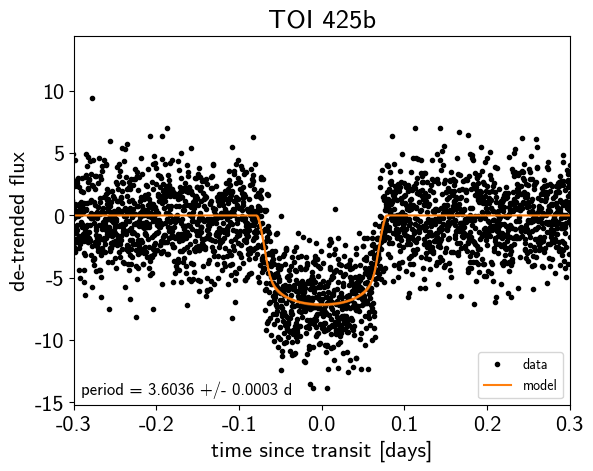

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

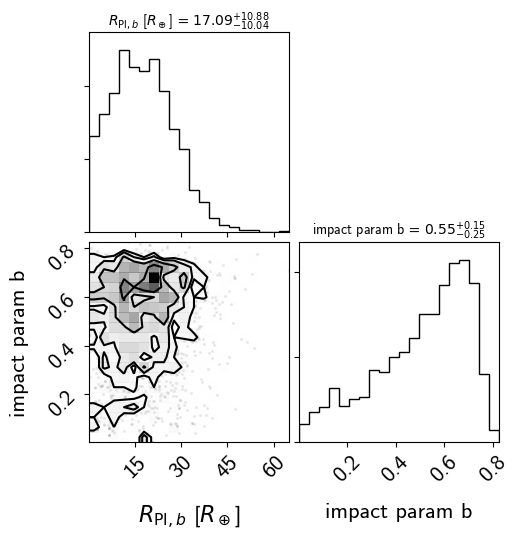

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

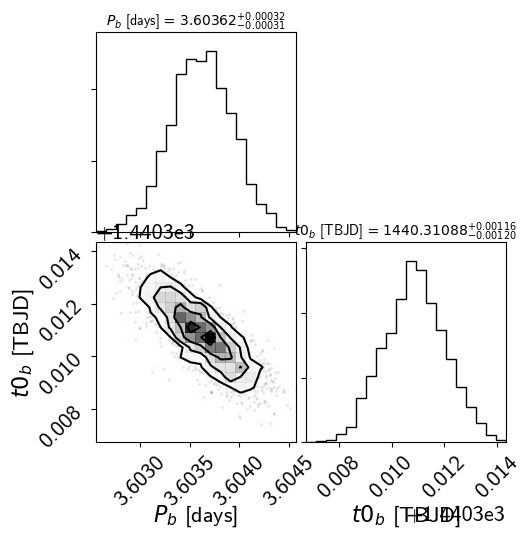

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

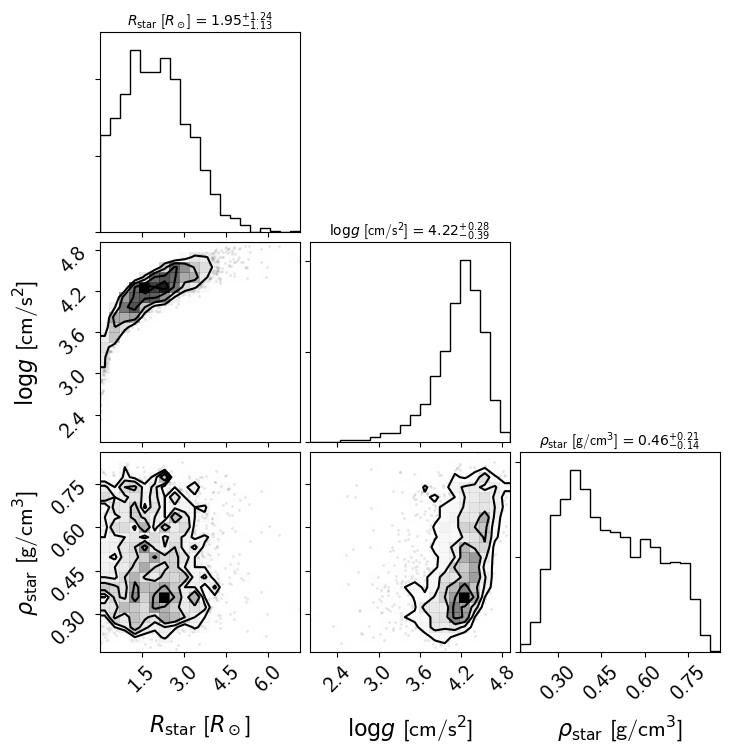

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3